# Constructing a right-hand-side function for the ODE solver #

The idea is to construct a RHS function for rhe ODE solver from a Lagrangian, using sympy. The output function should be a C++ file that contains a few functions that compute the needed right-hand sides. These should be templated over the numeric type so that they can work with either `long double` or `__quad128__`. 

The right-hand side functions should be:

* `newton` - simple newtonian motion
* `newton_jac` - simple newtonian motion, but computing the derivatives of the trajectory with respect to all parameters as well
* `ppn` - parameterized post-Newtonian motion
* `ppn_jac` - parameterized post-Newtonian motion with derivatives

See also the notebook `n-ppn`, which contains a previous version of this.


## Lagrangians from the literature

Nordtvedt 1985 works out the Lagrangian for motion in a parameterized post-Newtonian framework. Given such a Lagrangian $L$, the motion of each body is governed by
$$
\frac{d}{dt}\left(\frac{\partial L}{\partial v_i}\right) = \frac{\partial L}{\partial r_i}.
$$
This Lagrangian is given by
$$
L = -\sum_i M(I)_i\left(1-\frac{v_i^2}{2}-\frac{v_i^4}{8}\right) + \frac{1}{2}\sum_{i,j}\frac{\Gamma_{ij}}{r_{ij}}\left(1+\frac{v_i^2+v_j^2}{2}-\frac{3v_i\cdot v_j}{2}-\frac{(v_i\cdot\hat r_{ij})(v_j\cdot\hat r_{ij})}{2}\right)
+ \frac{\gamma}{2}\sum_{i,j}\frac{\Theta_{ij}}{r_{ij}}(v_i-v_j)^2+\left(\frac{1}{2}-\beta\right)\sum_{i,j,k}\frac{\Gamma_{ijk}}{r_{ij}r_{ik}}.
$$

What are all these alarming constants? Well, $\beta$ and $\gamma$ are standard post-Newtonian parameters having the value $1$ in GR. $M(I)_i$ converges to $m_i$ if body $i$ is noncompact, and similarly if all the bodies involved are noncompact $\Gamma_{ij}=m_im_j$, $\Theta_{ij}=m_im_j$, and $\Gamma_{ijk} = m_im_jm_k$. Even when compact, $\Gamma_{ij}$ and $\Theta_{ij}$ are symmetric in their indices, and $\Gamma_{ijk}$ is symmetric in the last two indices. 

If the pulsar is the only compact body in the system, then all these parameters are specified by simply specifying a set of masses for the pulsar: $M(G)$, $M(\gamma)$, $M(\beta)$, $M'(\beta)$. $M(I)$ is an inertial mass, the one that appears in $F=Ma$. $M(G)$ is the gravitational mass that appears in Kepler's laws for distant bodies. $M(\gamma)$ is associated with the deflection of light. 

## Constructing the Lagrangians in sympy form

In [1]:
from sympy import *
#%load_ext sympy.interactive.ipythonprinting
init_printing()

### The PPN Lagrangian

Because the PPN Lagrangian is big and messy, we're going to construct it as a sum of parts, divided up as the expression above, and referred to by which PPN parameters appear.

We need to create variable objects for each variable sympy will work with. This includes, for example, all nine position variables, but also all the $\Gamma$ and $\Theta$ variables; we take (anti-) symmetry into account.

In [2]:
var('gamma')
var('beta')
ms = [Symbol('m%d' % i) for i in range(3)]
gammas = []
thetas = []
gamma3s = []
xs = []
vs = []
for i in range(3):
    gammas.append([])
    thetas.append([])
    gamma3s.append([])
    xs.append([])
    vs.append([])
    for j in range(3):
        xs[-1].append(Symbol('x%d%d'%(i,j)))
        vs[-1].append(Symbol('v%d%d'%(i,j)))
        gamma3s[-1].append([])
        if i==j:
            gammas[-1].append(0)
            thetas[-1].append(0)
        else:
            gammas[-1].append(Symbol('Gamma%d%d' % (min(i,j),max(i,j))))
            thetas[-1].append(Symbol('Theta%d%d' % (min(i,j),max(i,j))))
        for k in range(3):
            if i==j or i==k:
                gamma3s[-1][-1].append(0)
            else:    
                gamma3s[-1][-1].append(Symbol('Gamma%d%d%d' % (i,min(j,k),max(j,k))))


To simplify the expressions, we create variables for the squared velocities of the three objects. As long as we provide appropriate derivatives for these, the results willl be right, and I had trouble with the simplifications when I used the expressions for these directly. One can always substitute the values back in if it comes to that.

In [3]:
mag_vs_sq = []
mag_vs_sq_f = []
for i in range(3):
    mag_vs_sq.append(Symbol('vs%d' % i))
    mag_vs_sq_f.append(0)
    for j in range(3):
        mag_vs_sq_f[-1] += vs[i][j]*vs[i][j]

Kinetic energy terms in the Lagrangian. Since this is 1PPN order there's a term beyond $mv^2/2$.

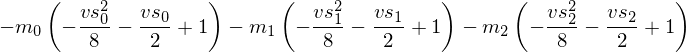

In [4]:
Lm = 0
for i in range(3):
    Lm += -ms[i]*(1-mag_vs_sq[i]/2-mag_vs_sq[i]**2/8)
Lm

Similarly we construct variables for all the pairwise distances.

In [7]:
mag_r = []
mag_r_f = []
for i in range(3):
    mag_r.append([])
    mag_r_f.append([])
    for j in range(3):
        if i==j:
            mag_r[-1].append(0)
            mag_r_f[-1].append(0)
        else:    
            mag_r[-1].append(Symbol('r%d%d'%(min(i,j),max(i,j))))
            mag_r_f[-1].append(0)
                         
            for k in range(3):
                mag_r_f[-1][-1] += (xs[i][k]-xs[j][k])**2
            mag_r_f[-1][-1] **= Rational(1,2)

$\Theta$ terms.

In [9]:
Lt = 0
for i in range(3):
    for j in range(3):
        if i==j:
            continue
        nsq = 0
        for k in range(3):
            nsq += (vs[i][k]-vs[j][k])**2
        Lt += gamma/2*thetas[i][j]/mag_r[i][j]*nsq
#Lt

Two-index $\Gamma$ terms.

In [11]:
Lg = 0
for i in range(3):
    for j in range(3):
        if i==j:
            continue
        brack = 1 + (mag_vs_sq[i]+mag_vs_sq[j])/2
        b3a = 0
        b3b = 0
        for k in range(3):
            brack += -Rational(3,2)*(vs[i][k]*vs[j][k])
            b3a += vs[i][k]*(xs[i][k]-xs[j][k])/mag_r[i][j]
            b3b += vs[j][k]*(xs[i][k]-xs[j][k])/mag_r[i][j] # FIXME: check the sign here
        brack += -Rational(1,2)*b3a*b3b
        Lg += Rational(1,2)*gammas[i][j]/mag_r[i][j]*brack
#Lg

Three-index $\Gamma$ terms. These are nonlinear modifications to the potential of and between bodies, and are largely responsible for Mercury's (excess) periastron advance.

In [13]:
Lf = 0
for i in range(3):
    for j in range(3):
        if i==j:
            continue
        for k in range(3):
            if i==k:
                continue
            Lf += (Rational(1,2)-beta)*gamma3s[i][j][k]/mag_r[i][j]/mag_r[i][k]
#Lf

In [14]:
L = Lg + Lt + Lm + Lf

### The Newtonian Lagrangian

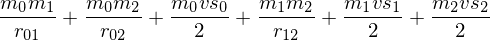

In [15]:
Lds_N = 0
for i in range(3):
    Lds_N += Rational(1,2)*ms[i]*mag_vs_sq[i]
    for j in range(3):
        if j==i:
            continue
        Lds_N += Rational(1,2)*ms[i]*ms[j]/mag_r[i][j]
Lds_N


## Extracting equations of motion

In [18]:
a_s = []
for i in range(3):
    a_s.append([])
    for j in range(3):
        a_s[-1].append(Symbol("a_%d%d" % (i,j)))
a_s

Because we've introduced various shorthand symbols and because we know about the relationships between, time, position, velocity, and acceleration, we define our own differentiation functions that do the right thing.

In [19]:
def diff_mag_r_f(ii,jj,i,j):
    if ii==jj:
        return 0
    if i==ii:
        return (xs[ii][j]-xs[jj][j])/mag_r[ii][jj]
    if i==jj:
        return (xs[jj][j]-xs[ii][j])/mag_r[ii][jj]
    return 0
def partial_vs(expr,i,j):
    r = diff(expr,vs[i][j])
    for ii in range(3):
        r += diff(expr,mag_vs_sq[ii])*diff(mag_vs_sq_f[ii],vs[i][j])
    return r
def partial_xs(expr,i,j):
    r = diff(expr,xs[i][j])
    for ii in range(3):
        for jj in range(ii+1,3):
            r += diff(expr,mag_r[ii][jj])*diff_mag_r_f(ii,jj,i,j)
    return r
def d_by_dt(expr):
    r = 0
    for i in range(3):
        for j in range(3):
            r += partial_vs(expr,i,j)*a_s[i][j]
            r += partial_xs(expr,i,j)*vs[i][j]
    return r

### Newtonian case

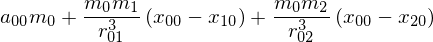

In [21]:
Ln = Lds_N
equations_n = [d_by_dt(partial_vs(Ln,i,j))-partial_xs(Ln,i,j) for i in range(3) for j in range(3)]
equations_n[0]

This we can always write as $M(x,v)a = b(x,v)$ for some matrix $M$. In this case the matrix will be diagonal and independent of $x$ and $v$, but in the PPN case neither is true and some further work will be required.

In [22]:
Mn = []
bn = []
for m, expr in enumerate(equations_n):
    Mn.append([])
    bm = -expr
    for i in range(3):
        for j in range(3):
            bm = bm.subs(a_s[i][j],0)
            Mn[-1].append(diff(expr,a_s[i][j]))
    bn.append(bm)

In [23]:
Mn

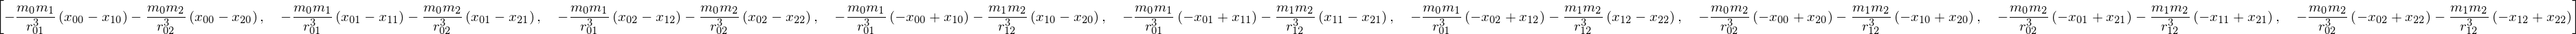

In [24]:
bn

### PPN case

We will try to do the same thing here: extract the equations into a form $Ma = b$; we can avoid the need for matrix inversion by using the fact that all the off-diagonal terms in the matrix are already at 1PPN order, so we can use a truncated series expansion for matrix inversion.

In [25]:
equations = [d_by_dt(partial_vs(L,i,j))-partial_xs(L,i,j) for i in range(3) for j in range(3)]

In [26]:
M = []
b = []
for m, expr in enumerate(equations):
    M.append([])
    bm = -expr
    for i in range(3):
        for j in range(3):
            bm = bm.subs(a_s[i][j],0)
            M[-1].append(diff(expr,a_s[i][j]))
    b.append(bm)

Our goal is to separate out the terms by their PPN order - `M0` and `b0` will contain all the zero-order (Newtonian) terms, and `M1` and `b1` will contain only 1PPN terms. This will allow us to drop any product of `M1` and `b1` with themselves or each other.

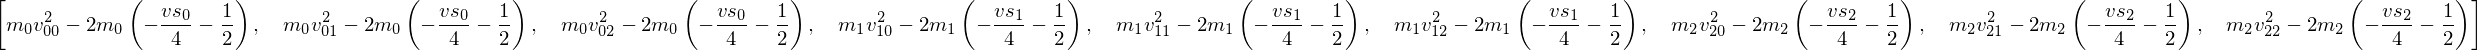

In [31]:
M0 = []
M0i = []
for i in range(9):
    M0.append([])
    M0i.append([])
    for j in range(9):
        if i==j:
            M0[-1].append(M[i][j])
            for ii in range(3):
                for jj in range(3):
                    M0[-1][-1] = M0[-1][-1].subs(gammas[ii][jj],0)
                    M0[-1][-1] = M0[-1][-1].subs(thetas[ii][jj],0)
            M0i[-1].append(M0[-1][-1]**(-1))
        else:
            M0[-1].append(0)
            M0i[-1].append(0)
[M0[i][i] for i in range(9)]

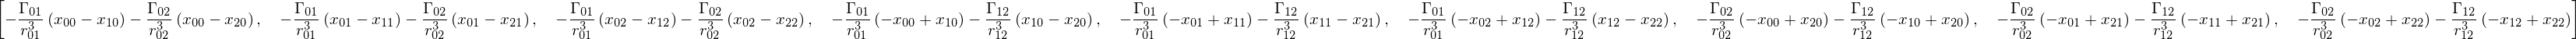

In [32]:
b0 = b[:]
for k in range(9):
    for i in range(3):
        b0[k] = b0[k].subs(mag_vs_sq[i],0)
        for j in range(3):
            b0[k] = b0[k].subs(vs[i][j],0)
            for l in range(3):
                if i==j or i==l:
                    continue
                b0[k] = b0[k].subs(gamma3s[i][j][l],0)
                
b0

In [33]:
M0 = Matrix(M0)
M1 = Matrix(M)-M0
b0 = Matrix(b0)
b1 = Matrix(b)-b0
M0i = Matrix(M0i)

We want to solve 
$$
(M_0+M_1)a = b_0+b_1
$$
where among other things the subscripts denote the order of dependence on $v^2/c^2$ or $r_S/r$ (which are of about equal magnitude). We can do this by direct matrix inversion, but since we have already dropped everything of second order, we should be able to do better:
$$
(M_0^{-1}-M_0^{-1}M_1M_0^{-1})(M_0+M_1) = I + M_0^{-1}M_1 - M_0^{-1}M_1 + O(v^4/c^4)
$$
or
$$
a = M_0^{-1}(b_0+b_1) - M_0^{-1}M_1M_0^{-1}b_0 + O(v^4/c^4).
$$

In [42]:
rhs = M0i*(b0+b1-(M1*M0i)*b0)

### Newtonian

This is much simpler because we don't need the matrix-inversion trick.

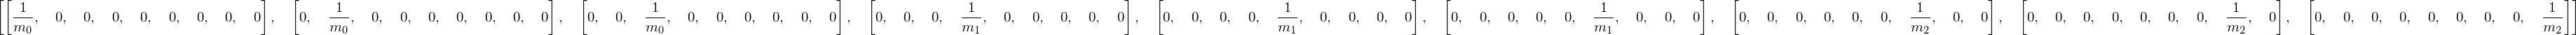

In [39]:
Mni = [[Mn[i][j] for j in range(len(Mn[0]))] for i in range(len(Mn))]
for j in range(len(Mn)):
    Mni[j][j] = Mn[j][j]**(-1)
Mni

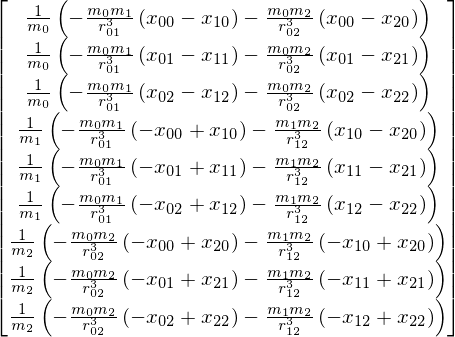

In [41]:
rhs_n = Matrix(Mni)*Matrix(bn)
rhs_n

## Time dilation

Pulse phases are measured in pulsar proper time, which is related to dynamical time (the time variable of the ODE) via time dilation. This includes both special and general relativistic dilation. These can be evaluated by computing a time dilation factor $\gamma$, which will be a function of the positions, masses, and velocities. This factor is the rate at which pulsar time runs, and therefore the pulsar time must be computed as the integral of (the inverse of) this factor. It may improve accuracy to integrate the difference between pulsar proper time and dynamical time. In any case, if we want to compute derivatives with respect to various parameters, we will need to know the derivatives of this quantity as well.

## Derivatives with respect to parameters

It is possible to live with the ability to integrate the ODE for any given set of initial conditions and parameters. But because we are pushing the limits of numerical accuracy, the solution's dependence on these parameters will develop a "roughness" both due to round-off error and due to the numerous branches involved in the calculation. This impedes numerical minimization algorithms and complicates the fitting process. The roughness could be reduced by using fixed step sizes in the numerical solution, but the root-finding process would still introduce such jumps. On the other hand, the most severe impact of this roughness is on numerical differentiation, and we have the tools to hand to compute analytical derivatives. Let's see how hard that will be.

We can describe our situation thus:

We seek to solve an ordinary differential equation
$$
\dot Y = R(Y,P)
$$
obtaining a smooth function $Y(t,P)$, where $P$ is a vector of parameters, and where $Y(0) = K(P)$ is specified. Further, we have an additional function $D(Y)$, and we are interested in the values of $Y$ at times $t_i$ where
$$
t_i + D(Y(t_i), P) = T_i
$$
for a list of values $T_i$. For each $t_i$ we compute $\tau_i = T(Y(t_i))$, the pulsar proper time at each observation. We then use a linear model, involving spin frequency, spin frequency derivative, telescope-specific jumps, and possibly frequency-dependent shifts to obtain a pulse phase $\phi_i$ for each observation. We compare these phases to specific integer turn numbers $n_i$ to obtain a residual $r_i = \phi_i - n_i$. We also have an uncertainty $\u_i$, so that the quantity we are trying to minimize is
$$
E = \sum_i \frac{\phi_i-n_i}{u_i}.
$$
(Note that for Bayesian calculations there is an additional term due to the analytical marginalization over the linear parameters.) Our goal is therefore to compute $\partial E/\partial P_i$, or $D_P E$ for each input parameter in the parameter vector $P$. Or, for understanding or use in a Levenberg-Marquardt method, we might want derivatives of all the residuals with respect to all the parameters.

Let us walk the derivatives through. At each stage we will have a matrix, the derivatives of each element of a vector with respect to a vector of parameters (ultimately $P$). The derivatives of $D_P Y(0) = (JK)(P)$, where $J$ is the Jacobian matrix of partial derivatives of the function $K$. The derivatives of $Y(t_i)$ with respect to $P$ enter in through both the parameters and the initial conditions.

The short version: from the ODE solver we will need the derivatives of $Y(t_i)$ with respect to $P$, and the derivative of $Y(t_i)$ with respect to $t_i$. The former we can obtain by integrating the Jacobian of $R$, and the latter comes out of the ODE solver, either directly from the dense output or by calling $R$.